In [1]:
import sys, os, json, math, re, shapely
sys.path.append('backend/app/')
import xarray as xr, numpy as np, geopandas as gpd
import pandas as pd, dask.array as da
from Functions import functions, gridFunctions
from scipy.interpolate import Rbf, griddata, interp1d
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.ndimage import distance_transform_edt, gaussian_filter
from meshkernel import MeshKernel, GeometryList

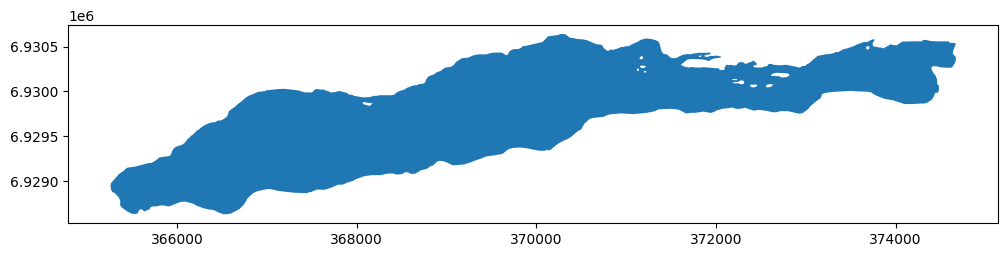

In [2]:
lake, depth = gpd.read_file('lake.geojson'), gpd.read_file('depth.geojson')
fig, ax = plt.subplots(figsize=(12, 10))
lake.plot(ax=ax)
plt.show()

In [3]:
lake["geometry"] = lake.geometry.apply(lambda geo: gridFunctions.remove_holes(geo, 0))
coords, polygon = [], lake["geometry"].iloc[0]
if polygon.geom_type == "Polygon":
    coords = list(polygon.exterior.coords)
elif polygon.geom_type == "MultiPolygon":
    for poly in polygon.geoms:
        coords.extend(list(poly.exterior.coords))
vertices_with_id = [{"id": i, "coord": shapely.geometry.Point((coord[0], coord[1]))} for i, coord in enumerate(coords)]
point = gpd.GeoDataFrame(vertices_with_id, geometry="coord", crs=lake.crs)

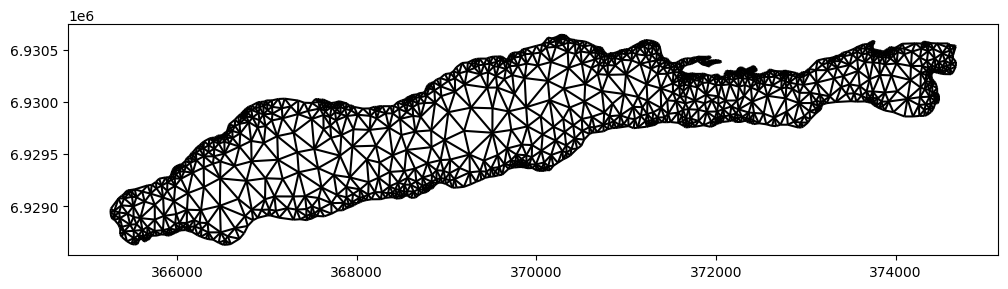

In [4]:
lake["geometry"] = lake.geometry.apply(lambda geo: gridFunctions.remove_holes(geo, 0))
x, y = lake.geometry.iloc[0].exterior.xy
x, y = np.array(x), np.array(y)
polygon = GeometryList(x, y)
mk = MeshKernel()
mk.mesh2d_make_triangular_mesh_from_polygon(polygon, scale_factor=50)
fig, ax = plt.subplots(figsize=(12, 3))
mk.mesh2d_get().plot_edges(ax, color="black")
plt.show()

In [5]:
grid_uds = gridFunctions.netCDF_creator(mk, depth)
# # Write to NetCDF
# grid_uds.to_netcdf("net.nc")
grid_uds

<xarray.Dataset> Size: 469kB
Dimensions:                      (mesh2d_nNodes: 1575, mesh2d_nEdges: 4130,
                                  Two: 2, mesh2d_nFaces: 2556,
                                  mesh2d_nMax_face_nodes: 4)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 13kB 3.704e+05 ... 3...
    mesh2d_node_y                (mesh2d_nNodes) float64 13kB 6.931e+06 ... 6...
  * mesh2d_nNodes                (mesh2d_nNodes) int64 13kB 0 1 2 ... 1573 1574
Dimensions without coordinates: mesh2d_nEdges, Two, mesh2d_nFaces,
                                mesh2d_nMax_face_nodes
Data variables:
    projected_coordinate_system  int32 4B -2147483647
    mesh2d                       int32 4B 0
    mesh2d_node_z                (mesh2d_nNodes) float64 13kB dask.array<chunksize=(1575,), meta=np.ndarray>
    mesh2d_edge_x                (mesh2d_nEdges) float64 33kB dask.array<chunksize=(4130,), meta=np.ndarray>
    mesh2d_edge_y                (mesh2d_nEdges) float64 33kB dask.array<chunksize=(4130,), meta=np.ndarray>
    mesh2d_edge_nodes            (mesh2d_nEdges, Two) int32 33kB dask.array<chunksize=(4130, 2), meta=np.ndarray>
    mesh2d_face_nodes            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 82kB dask.array<chunksize=(2556, 4), meta=np.ndarray>
    mesh2d_edge_faces            (mesh2d_nEdges, Two) int32 33kB dask.array<chunksize=(4130, 2), meta=np.ndarray>
    mesh2d_face_x                (mesh2d_nFaces) float64 20kB dask.array<chunksize=(2556,), meta=np.ndarray>
    mesh2d_face_y                (mesh2d_nFaces) float64 20kB dask.array<chunksize=(2556,), meta=np.ndarray>
    mesh2d_face_x_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 82kB dask.array<chunksize=(2556, 4), meta=np.ndarray>
    mesh2d_face_y_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 82kB dask.array<chunksize=(2556, 4), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.9 UGRID-1.0
    institution:  Private
    references:   vanlnNTNU@gmail.com
    source:       Created with meshkernel 8.2.2, xugrid 0.14.3 and dfm_tools ...
    history:      Created on 2026-02-11T15:21:20, vanln

In [6]:
new_grid = functions.unstructuredGridCreator(grid_uds)
fig, ax = plt.subplots(figsize=(12, 8))
new_grid.to_crs(lake.crs).plot(ax=ax)
plt.show()

AttributeError: 'memoryview' object has no attribute 'astype'

: 

: 

In [ ]:
data = xr.open_dataset(r'backend\static\samples\grid\Grid_net.nc')
data

<xarray.Dataset> Size: 919kB
Dimensions:            (mesh2d_nNodes: 2645, mesh2d_nEdges: 7579, Two: 2,
                        mesh2d_nFaces: 4935, mesh2d_nMax_face_nodes: 4)
Coordinates:
    mesh2d_node_x      (mesh2d_nNodes) float64 21kB ...
    mesh2d_node_y      (mesh2d_nNodes) float64 21kB ...
Dimensions without coordinates: mesh2d_nNodes, mesh2d_nEdges, Two,
                                mesh2d_nFaces, mesh2d_nMax_face_nodes
Data variables:
    wgs84              int32 4B ...
    mesh2d             int32 4B ...
    mesh2d_node_z      (mesh2d_nNodes) float64 21kB ...
    mesh2d_edge_x      (mesh2d_nEdges) float64 61kB ...
    mesh2d_edge_y      (mesh2d_nEdges) float64 61kB ...
    mesh2d_edge_nodes  (mesh2d_nEdges, Two) int32 61kB ...
    mesh2d_face_nodes  (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 158kB ...
    mesh2d_edge_faces  (mesh2d_nEdges, Two) float64 121kB ...
    mesh2d_face_x      (mesh2d_nFaces) float64 39kB ...
    mesh2d_face_y      (mesh2d_nFaces) float64 39kB ...
    mesh2d_face_x_bnd  (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 158kB ...
    mesh2d_face_y_bnd  (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 158kB ...
Attributes:
    institution:  Deltares
    references:   http://www.deltares.nl
    source:       RGFGRID 7.03.00.77422. Model: ---
    history:      Created on 2024-09-06T11:08:32+0200, RGFGRID
    Conventions:  CF-1.8 UGRID-1.0 Deltares-0.10

: 

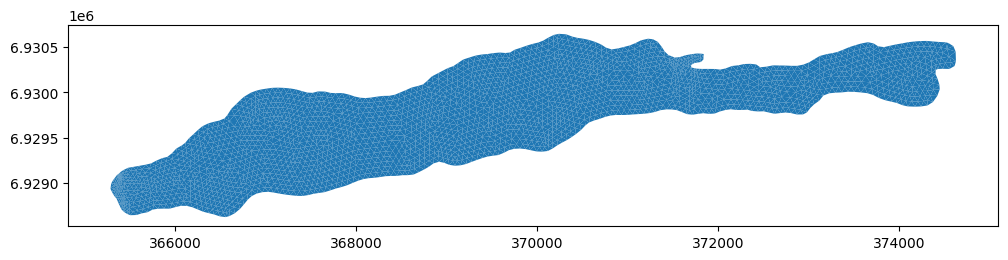

: 

In [ ]:
grid = functions.unstructuredGridCreator(data)
fig, ax = plt.subplots(figsize=(12, 8))
grid.to_crs(lake.crs).plot(ax=ax)
plt.show()

In [ ]:
grid.to_crs(epsg=4326).to_file('grid_delft3d.geojson', driver='GeoJSON')

: 

: 